# Project4 

Team member: Xin Xiang

## Introduction

The goal of this project is using diagnose information to predict the result of diagnose. In this project, we have done EDA, data preperation, feature engineering, data split, model training and result analyse.

## Import necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split

import statsmodels.stats.api as sms
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.tools.tools import add_constant
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    make_scorer,
    roc_auc_score,
    roc_curve,
    precision_recall_curve,
)

## Import dataset from Github

In [3]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ycwang15/Analytics_Programming/Data/Project%204%20DATA.csv"
)
df.head()

,Diagnosis,Age,Gender,PainType,BloodPres,Chol,FBSugar,RestECG,MaxHeartRate,ExAngina,STPeakSlope
0,0,63,1,1,145,233,1,2,150,0,3
1,2,67,1,4,160,286,0,2,108,1,2
2,1,67,1,4,120,229,0,2,129,1,2
3,0,37,1,3,130,250,0,0,187,0,3
4,0,41,0,2,130,204,0,2,172,0,1


## Data Overview

In [4]:
df.shape

(303, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   Diagnosis     303 non-null    int64
 1   Age           303 non-null    int64
 2   Gender        303 non-null    int64
 3   PainType      303 non-null    int64
 4   BloodPres     303 non-null    int64
 5   Chol          303 non-null    int64
 6   FBSugar       303 non-null    int64
 7   RestECG       303 non-null    int64
 8   MaxHeartRate  303 non-null    int64
 9   ExAngina      303 non-null    int64
 10  STPeakSlope   303 non-null    int64
dtypes: int64(11)
memory usage: 26.2 KB


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Diagnosis,303.0,0.937294,1.228536,0.0,0.0,0.0,2.0,4.0
Age,303.0,54.438944,9.038662,29.0,48.0,56.0,61.0,77.0
Gender,303.0,0.679868,0.467299,0.0,0.0,1.0,1.0,1.0
PainType,303.0,3.158416,0.960126,1.0,3.0,3.0,4.0,4.0
BloodPres,303.0,131.689769,17.599748,94.0,120.0,130.0,140.0,200.0
Chol,303.0,246.693069,51.776918,126.0,211.0,241.0,275.0,564.0
FBSugar,303.0,0.148515,0.356198,0.0,0.0,0.0,0.0,1.0
RestECG,303.0,0.990099,0.994971,0.0,0.0,1.0,2.0,2.0
MaxHeartRate,303.0,149.607261,22.875003,71.0,133.5,153.0,166.0,202.0
ExAngina,303.0,0.326733,0.469794,0.0,0.0,0.0,1.0,1.0


In [7]:
df.isnull().sum()

Diagnosis       0
Age             0
Gender          0
PainType        0
BloodPres       0
Chol            0
FBSugar         0
RestECG         0
MaxHeartRate    0
ExAngina        0
STPeakSlope     0
dtype: int64

In [8]:
df.duplicated().sum()

0



*   There are 303 rows and 11 columns in this dataset.
*   No missing values and duplicated values here which is a good news.
*   The data type of all of the columns are the "int64", we will convert some of them into appropriate type.





## Feature Engineering

* Convert certain columns from int to object.
* Replace the number in PainType and STeakSlope with appropriate object.
* Combine different number into one number, for example, both '1' and '2' in the column Diagnosis indicate the people has the heart disease, so we will replace 2 with 1, and the same situation in the column 'RestECG'.

### Convert the column PainType and STPeakSlope from int64 to object, and then using appropriate string to replace the each number.

In [9]:
df[['PainType','STPeakSlope']] = df[['PainType','STPeakSlope']].astype(str) 

In [10]:
df['PainType'] = df['PainType'].replace(str(1),'Typical Angina')
df['PainType'] = df['PainType'].replace(str(2),'atypical angina')
df['PainType'] = df['PainType'].replace(str(3),'nonanginal pain')
df['PainType'] = df['PainType'].replace(str(4),'asymptomatic')
df['PainType'].unique()

array(['Typical Angina', 'asymptomatic', 'non\x02anginal pain',
       'atypical angina'], dtype=object)

In [11]:
df['STPeakSlope'] = df['STPeakSlope'].replace(str(1),'upsloping')
df['STPeakSlope'] = df['STPeakSlope'].replace(str(2),'flat')
df['STPeakSlope'] = df['STPeakSlope'].replace(str(3),'downsloping')
df['STPeakSlope'].unique()

array(['downsloping', 'flat', 'upsloping'], dtype=object)

### Check the unique number in the column RestECG and Diagnosis.

In [12]:
df['RestECG'].value_counts()

0    151
2    148
1      4
Name: RestECG, dtype: int64

In [13]:
df['Diagnosis'].value_counts()

0    164
1     55
2     36
3     35
4     13
Name: Diagnosis, dtype: int64

### Change all numbers that greater than 1 into 1 in Diagnosis and RestECG column.

In [14]:
df['RestECG'] = df['RestECG'].replace(2,1)
df = df.replace({'Diagnosis' : { 2 : 1, 3 : 1, 4 : 1 }})
df.head()

,Diagnosis,Age,Gender,PainType,BloodPres,Chol,FBSugar,RestECG,MaxHeartRate,ExAngina,STPeakSlope
0,0,63,1,Typical Angina,145,233,1,1,150,0,downsloping
1,1,67,1,asymptomatic,160,286,0,1,108,1,flat
2,1,67,1,asymptomatic,120,229,0,1,129,1,flat
3,0,37,1,nonanginal pain,130,250,0,0,187,0,downsloping
4,0,41,0,atypical angina,130,204,0,1,172,0,upsloping


## EDA 

### 1.Univariate Analysis

#### 1.1 Check the count plot for each categorical column.

In [15]:
cat_col = df[['Diagnosis','Gender','PainType','FBSugar','RestECG','ExAngina','STPeakSlope']].columns.to_list()
cat_col

['Diagnosis',
 'Gender',
 'PainType',
 'FBSugar',
 'RestECG',
 'ExAngina',
 'STPeakSlope']

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretatio

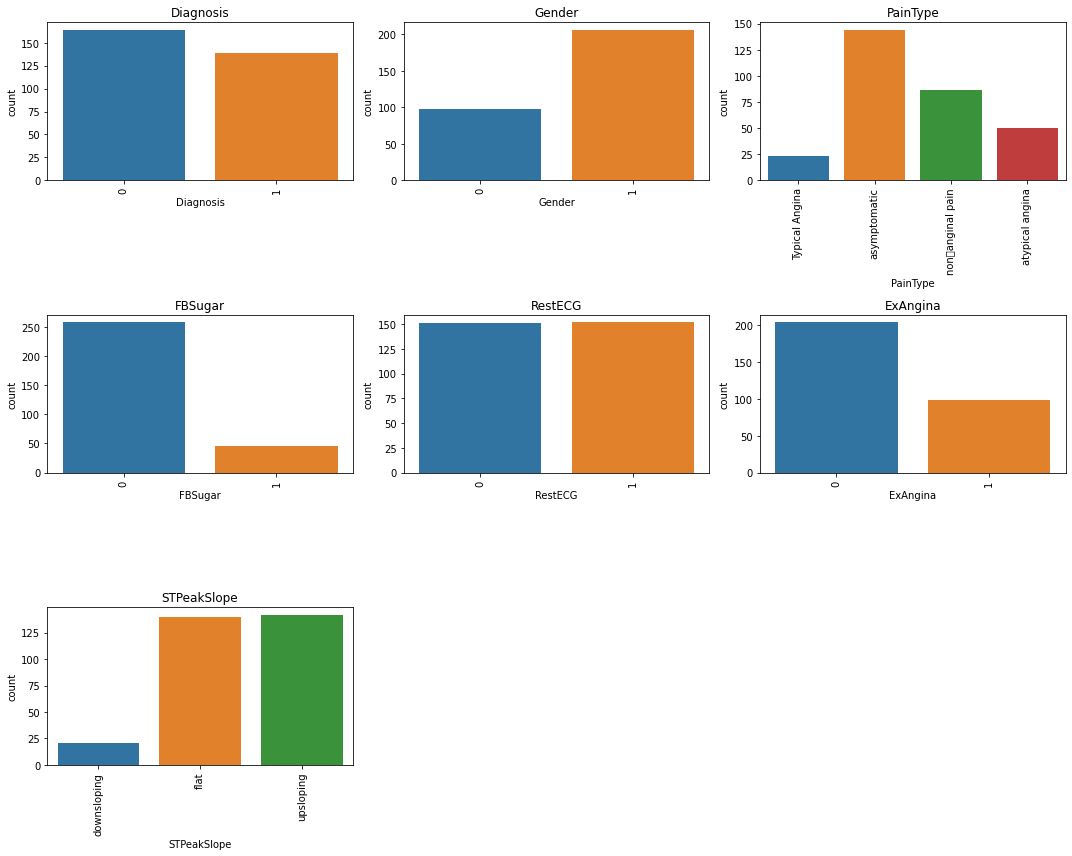

In [16]:
plt.figure(figsize=(15, 12))
for i, j in enumerate(cat_col):
    plt.subplot(3, 3, i + 1)
    sns.countplot(df[j])
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(j)

plt.show()

In [17]:
for i in cat_col:
    print(df[i].value_counts(normalize = True))
    print("-" * 50)

0    0.541254
1    0.458746
Name: Diagnosis, dtype: float64
--------------------------------------------------
1    0.679868
0    0.320132
Name: Gender, dtype: float64
--------------------------------------------------
asymptomatic        0.475248
nonanginal pain    0.283828
atypical angina     0.165017
Typical Angina      0.075908
Name: PainType, dtype: float64
--------------------------------------------------
0    0.851485
1    0.148515
Name: FBSugar, dtype: float64
--------------------------------------------------
1    0.50165
0    0.49835
Name: RestECG, dtype: float64
--------------------------------------------------
0    0.673267
1    0.326733
Name: ExAngina, dtype: float64
--------------------------------------------------
upsloping      0.468647
flat           0.462046
downsloping    0.069307
Name: STPeakSlope, dtype: float64
--------------------------------------------------


**Observations**
* Over half of the people got the heart disease.
* Nearly 70% of people in this dataset are male.
* asymptomatic is the most common pain type which over47%, followed by nonanginal pain.
* And over 85% people fasting blood sugar > 120 mg/dl.
* Half of Resting echocardiogram are normal and half are abnormal.
* Over 2/3 of people induced angina present.
* Upsloping and flat are the two most common slope of peak exercise which around 46%, and downsloping only has 6.9% of people.

#### 1.2 Check the histogram for each continuous column

In [18]:
distribution_col = df[['Age','BloodPres','Chol','MaxHeartRate']].columns.to_list()
distribution_col

['Age', 'BloodPres', 'Chol', 'MaxHeartRate']

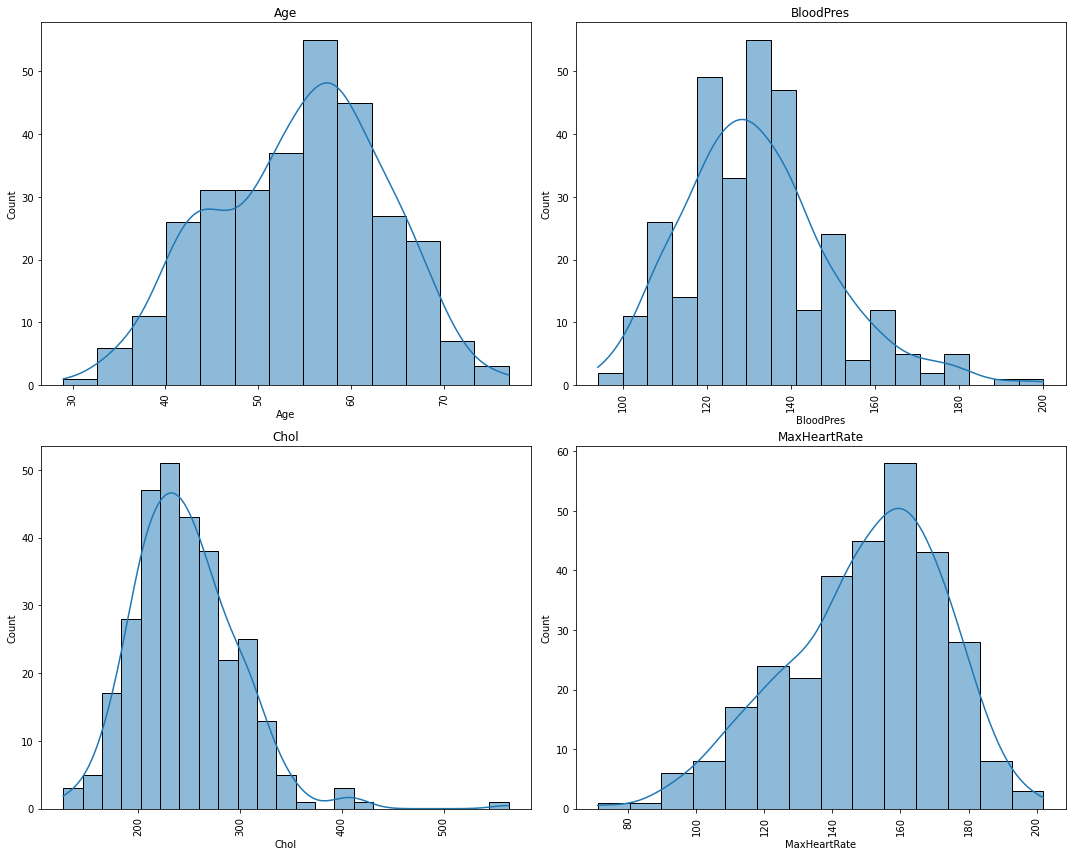

In [19]:
plt.figure(figsize=(15, 12))
for i, j in enumerate(distribution_col):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df[j],kde=True)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title(j)

plt.show()

**Observations**
* Most people are around 55 years old. And the Age distribution is almost normal distribution.
* Slight right skew of Blood pressure distribution, and most people's blood pressure are around 135.
* Right skew of Chol, most data locate around 240.
* Slight left skew of MaxHearRate, most data locate around 160.

#### 1.3 Check Outlier for each continuous data type column.

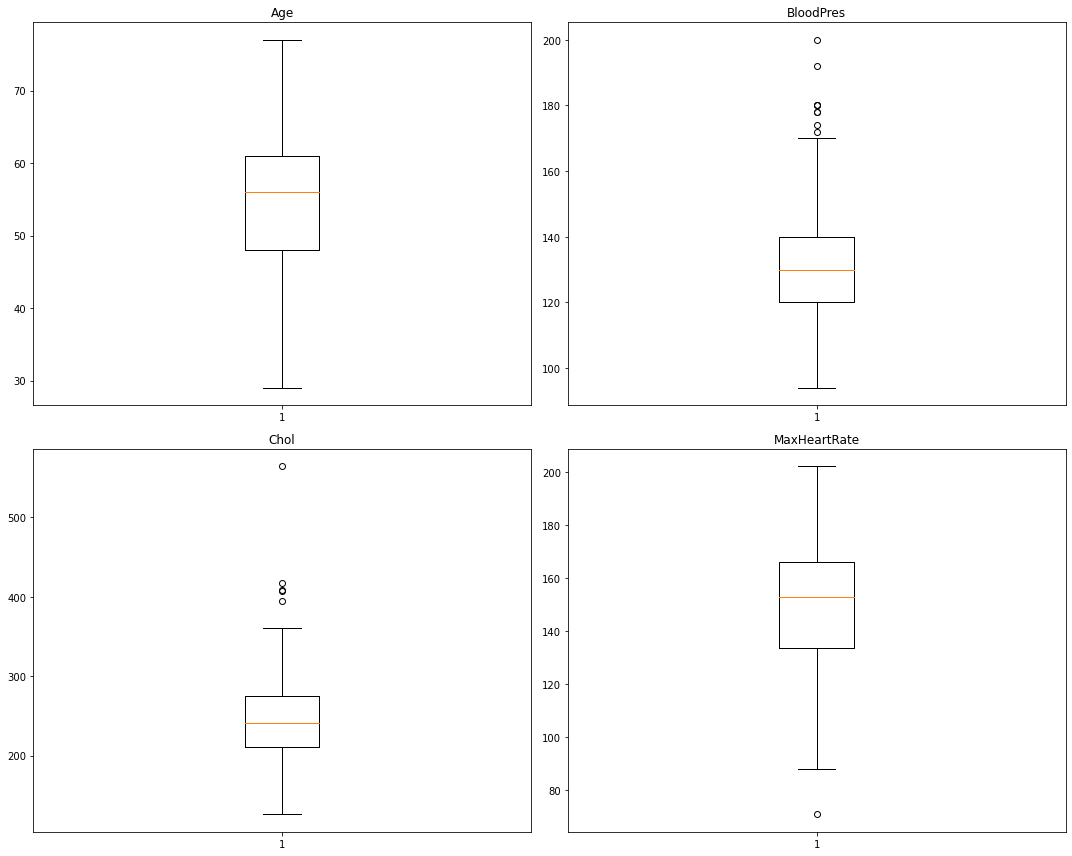

In [20]:
plt.figure(figsize=(15, 12))

for i, j in enumerate(distribution_col):
    plt.subplot(2, 2, i + 1)
    plt.boxplot(df[j], whis=1.5)
    plt.tight_layout()
    plt.title(j)

* There are several outliers in the BloodPress and MaxHeartRate column, but we are going to keep these outliers, because all of them are real data, and based on the histogram above, they are not the matter.

### 2.Bivariate Analysis

#### 2.1 Stack bar to show the relationship between Diagnosis and different categorical variables.

In [21]:
def Mstack_bar(data,b,a):
    sorter = data[a].value_counts().index[-1]
    tabl = pd.crosstab(data[b],data[a], normalize='index').sort_values(
       by=sorter,ascending=False)
    tabl.plot(rot=0,kind="bar", stacked=True,color=['steelblue', 'red'],figsize = (7,5))
    plt.legend(
        loc="lower left", frameon=False,
    )
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.figure(figsize=(10, 5))
    plt.show()

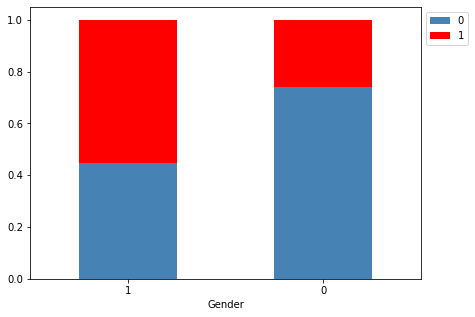

<Figure size 720x360 with 0 Axes>

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 2 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 2 missing from current font.
  font.set_text(s, 0, flags=flags)


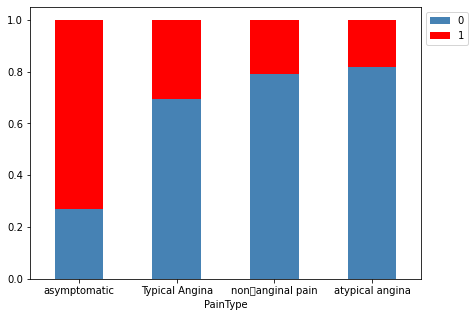

<Figure size 720x360 with 0 Axes>

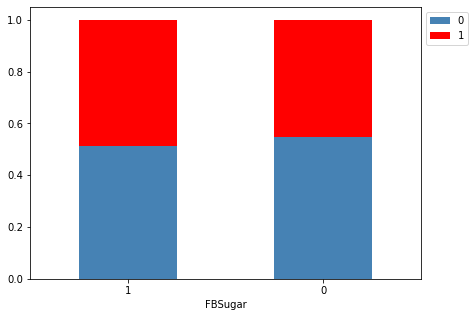

<Figure size 720x360 with 0 Axes>

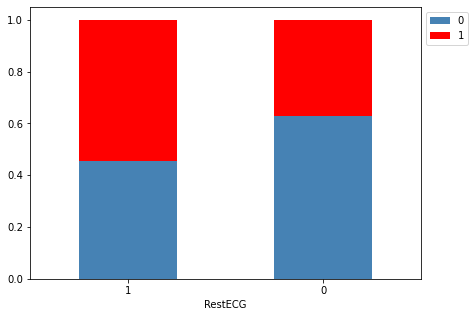

<Figure size 720x360 with 0 Axes>

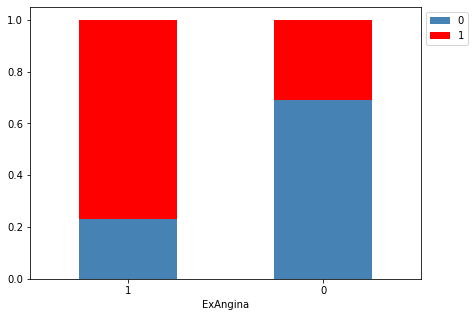

<Figure size 720x360 with 0 Axes>

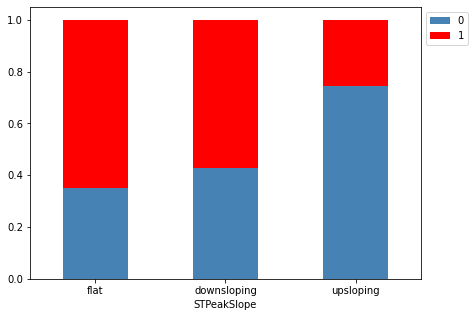

<Figure size 720x360 with 0 Axes>

In [22]:
stack_col = df[['Gender','PainType','FBSugar','RestECG','ExAngina','STPeakSlope']].columns.to_list()
for i in stack_col:
    Mstack_bar(df,i,'Diagnosis')
  

**Observations**
* Heart disease happened in a higher percentage among the male than the female.
* If a person got asymptomatic, he/she has a higher chance to get the heart disease.
* No matter whether a person's fast blooding greater than 120, they got the same percentage to get the heart disease.
* Higher risk to get heart disease if Resting echocardiogram results is abnormal.
* Greater risk of heart disease if exercise-induced angina is present.
* Flat and down sloping slopes at the peak of exercise are more likely to have heart disease

#### 2.2 Heatmap to show the correlation between different numerical variables.

In [23]:
col = df.select_dtypes(include=np.number).columns.tolist()

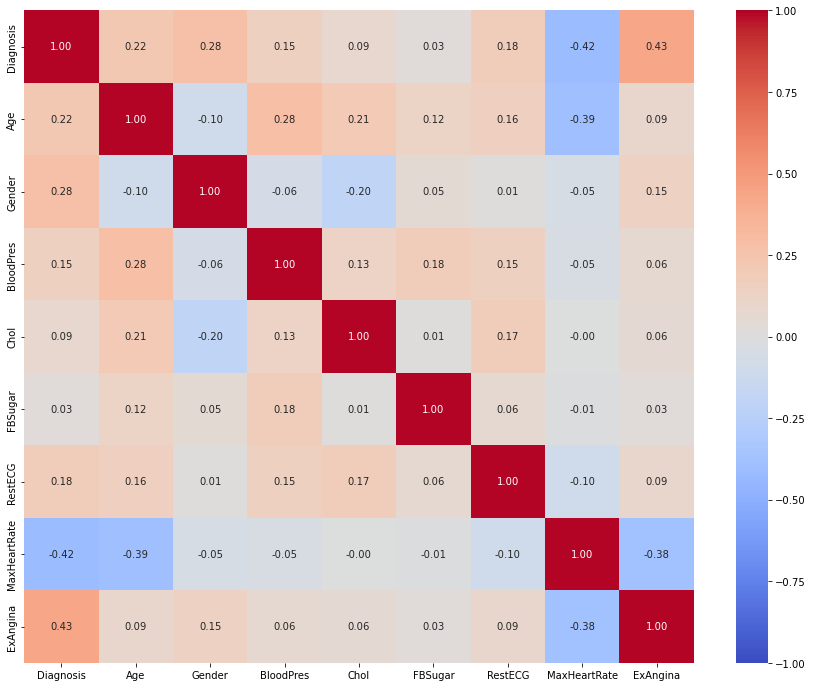

In [24]:
plt.figure(figsize=(15, 12))

sns.heatmap(
    df[col].corr(), annot=True, vmin=-1, vmax=1, fmt=".2f", cmap="coolwarm"
);

## Data Processing
**After we did EDA before, we need to do the data processing more profoundly.**
* We decided to choose all the columns except STPeakSlope column, this column has three different variables, but one of them: downsloping only has 6% overall, we don't want to overfit our model due to the sparse variable in this column, and due to the heart disease domain knowledge, this attribute is not as important as others in the dataset.
* And in this section, we are going to prepare our data to fit the model, it include data split into train and test dataset etc,.


In [25]:
df_final = df.iloc[:,0:10]
df_final.head()

,Diagnosis,Age,Gender,PainType,BloodPres,Chol,FBSugar,RestECG,MaxHeartRate,ExAngina
0,0,63,1,Typical Angina,145,233,1,1,150,0
1,1,67,1,asymptomatic,160,286,0,1,108,1
2,1,67,1,asymptomatic,120,229,0,1,129,1
3,0,37,1,nonanginal pain,130,250,0,0,187,0
4,0,41,0,atypical angina,130,204,0,1,172,0


### Preparing data for modeling
* Get dummy variable for categorical data.
* We will split the train and test dataset with the ratio of 8:2, and we also want different values (0 or 1) in the target variable('Diagnosis) that has the same ratio in both the train and test dataset.

In [26]:
final = pd.get_dummies(df_final, drop_first=True)
final

,Diagnosis,Age,Gender,BloodPres,Chol,FBSugar,RestECG,MaxHeartRate,ExAngina,PainType_asymptomatic,PainType_atypical angina,PainType_nonanginal pain
0,0,63,1,145,233,1,1,150,0,0,0,0
1,1,67,1,160,286,0,1,108,1,1,0,0
2,1,67,1,120,229,0,1,129,1,1,0,0
3,0,37,1,130,250,0,0,187,0,0,0,1
4,0,41,0,130,204,0,1,172,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
298,1,45,1,110,264,0,0,132,0,0,0,0
299,1,68,1,144,193,1,0,141,0,1,0,0
300,1,57,1,130,131,0,0,115,1,1,0,0
301,1,57,0,130,236,0,1,174,0,0,1,0


In [27]:
X = final.drop(["Diagnosis"], axis=1)
Y = final["Diagnosis"]

X = sm.add_constant(X)

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.20, random_state=1
)

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [28]:
print("Shape of Training set : ", X_train.shape)
print("Shape of test set : ", X_test.shape)
print("Percentage of classes in training set:")
print(y_train.value_counts(normalize=True))
print("Percentage of classes in test set:")
print(y_test.value_counts(normalize=True))

Shape of Training set :  (242, 12)
Shape of test set :  (61, 12)
Percentage of classes in training set:
0    0.53719
1    0.46281
Name: Diagnosis, dtype: float64
Percentage of classes in test set:
0    0.557377
1    0.442623
Name: Diagnosis, dtype: float64


## Model building

In [29]:
logit = sm.Logit(y_train, X_train.astype(float))
lg = logit.fit(disp=False)

print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      230
Method:                           MLE   Df Model:                           11
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3893
Time:                        23:13:52   Log-Likelihood:                -102.03
converged:                       True   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 1.667e-22
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.2762      2.579     -0.495      0.621      -6.331       3.779
Age                           0.0186      0.024      0.788      0.431      -0.028     

### Model evaluation criterion

* Before building the model, we need to identify which value should be maximum.

### The model may make wrong predictions:
* The model predicts that the people has heart disease, but in reality, the people doesn't have heart disease.
* The model predicts that the people doesn't have heart disease, but in reality, the people have heart disease.

### Which mistake is more important:
* The second is more important.
* If the mistake happens in the second situation, the people will die due to the wrong prediction, because they might not care about their bodies based on the forecast.


### How to reduce the losses?
* Recall Score can be used to be a important criterion, greater the recall score higher the chance to reduce the wrong.

### Create functions to calculate different metrics- Accuracy, Recall and Precision and plot the confusion matrix.

In [30]:
def model_performance_classification_statsmodels(
    model, predictors, target, threshold=0.5
):
    pred_temp = model.predict(predictors) > threshold
    pred = np.round(pred_temp)

    acc = accuracy_score(target, pred)  
    recall = recall_score(target, pred)  
    precision = precision_score(target, pred)  
    f1 = f1_score(target, pred)  

    df_perf = pd.DataFrame(
        {"Accuracy": acc, "Recall": recall, "Precision": precision, "F1": f1,},
        index=[0],
    )

    return df_perf

In [31]:
def confusion_matrix_statsmodels(model, predictors, target, threshold=0.5):

    y_pred = model.predict(predictors) > threshold
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

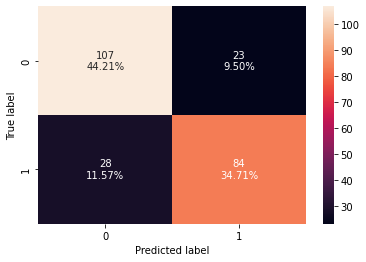

In [32]:
confusion_matrix_statsmodels(lg, X_train, y_train)

In [33]:
print("Training performance:")
Logistic_raw = model_performance_classification_statsmodels(lg, X_train, y_train)
Logistic_raw

Training performance:


,Accuracy,Recall,Precision,F1
0,0.789256,0.75,0.785047,0.767123



- The recall of the model is 0.75 and we will try to maximize it further

- The variables used to build the model might contain multicollinearity, which will affect the p-values

- We will have to remove multicollinearity from the data to get reliable coefficients and p-values

### Checking Multicollinearity

- In order to make statistical inferences from a logistic regression model, it is important to ensure that there is no multicollinearity present in the data.

In [34]:
vif_series = pd.Series(
    [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])],
    index=X_train.columns,
    dtype=float,
)
print(vif_series)

const                        229.059548
Age                            1.395224
Gender                         1.102567
BloodPres                      1.171241
Chol                           1.128925
FBSugar                        1.061637
RestECG                        1.108472
MaxHeartRate                   1.446678
ExAngina                       1.456927
PainType_asymptomatic          4.546796
PainType_atypical angina       2.846549
PainType_nonanginal pain      3.863035
dtype: float64


**Observation**:
- If Vif is higher than 5, we can say that the feature has high collinearity.
- We can noticed that there is no result higher than 5. So we don't need to get rid of any attributes.

### Removing High P-value variables

In [35]:
print(lg.summary())

                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      230
Method:                           MLE   Df Model:                           11
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3893
Time:                        23:13:52   Log-Likelihood:                -102.03
converged:                       True   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 1.667e-22
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        -1.2762      2.579     -0.495      0.621      -6.331       3.779
Age                           0.0186      0.024      0.788      0.431      -0.028     

* There are so many variables have a high p-value which greater than 0.05, we will drop them iteratively as sometimes p-values change after dropping a variable. 

**Remove the Age column**

In [36]:
X_train2 = X_train.drop(["Age"],axis=1)

logit2 = sm.Logit(y_train, X_train2.astype(float))
lg2 = logit2.fit(method="bfgs")

print(lg2.summary())

         Current function value: 0.422905
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      231
Method:                           MLE   Df Model:                           10
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3874
Time:                        23:13:52   Log-Likelihood:                -102.34
converged:                      False   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 6.028e-23
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.0056      2.10

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Remove the BloodPres column**

In [37]:
X_train3 = X_train2.drop(["BloodPres"],axis=1)

logit3 = sm.Logit(y_train, X_train3.astype(float))
lg3 = logit3.fit(method="bfgs")

print(lg3.summary())

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


         Current function value: 0.427718
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      232
Method:                           MLE   Df Model:                            9
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3805
Time:                        23:13:52   Log-Likelihood:                -103.51
converged:                      False   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 4.618e-23
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         1.2998      1.66

**Get rid of the Chol column**

In [38]:
X_train4 = X_train3.drop(["Chol"],axis=1)

logit4 = sm.Logit(y_train, X_train4.astype(float))
lg4 = logit4.fit(method="bfgs")

print(lg4.summary())

         Current function value: 0.431933
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      233
Method:                           MLE   Df Model:                            8
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3744
Time:                        23:13:52   Log-Likelihood:                -104.53
converged:                      False   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 2.944e-23
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.6346      1.49

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Get rid of the FBSugar column**

In [39]:
X_train5 = X_train4.drop(["FBSugar"],axis=1)

logit5 = sm.Logit(y_train, X_train5.astype(float))
lg5 = logit5.fit(method="bfgs")

print(lg5.summary())

         Current function value: 0.432163
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      234
Method:                           MLE   Df Model:                            7
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3740
Time:                        23:13:52   Log-Likelihood:                -104.58
converged:                      False   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 7.032e-24
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         2.6556      1.49

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Remove the PainType_non anginal pain column**

In [40]:
X_train6 = X_train5.drop(["PainType_nonanginal pain"],axis=1)

logit6 = sm.Logit(y_train, X_train6.astype(float))
lg6 = logit6.fit(method="bfgs")

print(lg6.summary())

         Current function value: 0.433381
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      235
Method:                           MLE   Df Model:                            6
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3723
Time:                        23:13:52   Log-Likelihood:                -104.88
converged:                      False   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 1.951e-24
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        2.1891      1.374  

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


**Remove the PainType atypical angina column**

In [41]:
X_train7 = X_train6.drop(["PainType_atypical angina"],axis=1)

logit7 = sm.Logit(y_train, X_train7.astype(float))
lg7 = logit7.fit(method="bfgs")

print(lg7.summary())

         Current function value: 0.438283
         Iterations: 35
         Function evaluations: 39
         Gradient evaluations: 39
                           Logit Regression Results                           
Dep. Variable:              Diagnosis   No. Observations:                  242
Model:                          Logit   Df Residuals:                      236
Method:                           MLE   Df Model:                            5
Date:                Sat, 19 Nov 2022   Pseudo R-squ.:                  0.3652
Time:                        23:13:52   Log-Likelihood:                -106.06
converged:                      False   LL-Null:                       -167.07
Covariance Type:            nonrobust   LLR p-value:                 1.175e-24
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     2.0585      1.374      1.498

/Users/yuchenwang/opt/anaconda3/lib/python3.9/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


* Now there is no p-value greater than 0.05

### Checking performance of the new model

**Training set performance**

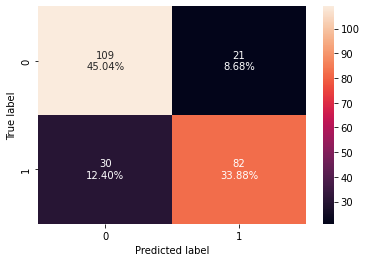

In [42]:
confusion_matrix_statsmodels(lg7, X_train7, y_train)

In [43]:
log_reg_model_train_perf = model_performance_classification_statsmodels(
    lg7, X_train7, y_train
)

print("Training performance:")
log_reg_model_train_perf

Training performance:


,Accuracy,Recall,Precision,F1
0,0.789256,0.732143,0.796117,0.762791


**Test set performance**

- We have to first drop the columns from the test set that were dropped from the training set.

In [44]:
X_test7 = X_test[list(X_train7.columns)]
X_test7

,const,Gender,RestECG,MaxHeartRate,ExAngina,PainType_asymptomatic
204,1.0,1,0,161,0,1
159,1.0,1,0,151,0,0
219,1.0,1,1,182,0,1
174,1.0,1,1,132,0,1
184,1.0,0,1,161,0,1
...,...,...,...,...,...,...
0,1.0,1,1,150,0,0
288,1.0,1,1,163,0,0
259,1.0,1,0,141,0,0
179,1.0,1,1,173,0,0


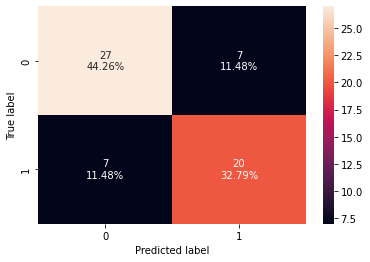

In [45]:
confusion_matrix_statsmodels(lg7, X_test7, y_test)

In [46]:
log_reg_model_test_perf = model_performance_classification_statsmodels(
    lg7, X_test7, y_test
)

print("Test performance:")
log_reg_model_test_perf

Test performance:


,Accuracy,Recall,Precision,F1
0,0.770492,0.740741,0.740741,0.740741


- The model is giving recall_score of 0.732 and 0.741 on the train and test sets respectively
- As the train and test performances are comparable, the model is not overfitting
- Moving forward to improve the performance of the model

### Model Performance Improvement

#### Trying to improve the Recall score by changing the threshold
* We are going to use precision and recall curve to get a optimal threshold

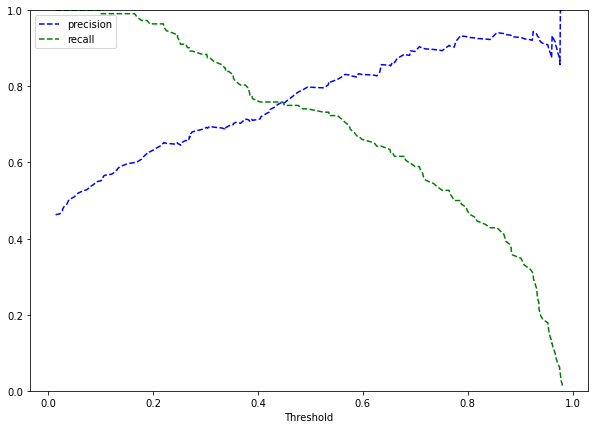

In [47]:
y_scores = lg7.predict(X_train7)
prec, rec, tre = precision_recall_curve(y_train, y_scores,)


def plot_prec_recall_vs_tresh(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="precision")
    plt.plot(thresholds, recalls[:-1], "g--", label="recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])


plt.figure(figsize=(10, 7))
plot_prec_recall_vs_tresh(prec, rec, tre)
plt.show()

* At the threshold of probably of 0.42, we get balanced recall and precision.

**Checking model performance on training set with new threshold**

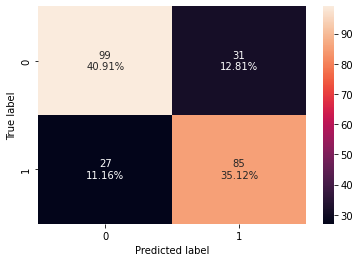

In [48]:
confusion_matrix_statsmodels(lg7, X_train7, y_train, threshold=0.42)

In [49]:
log_reg_model_train_perf_threshold_curve = model_performance_classification_statsmodels(
    lg7, X_train7, y_train, threshold=0.42
)
print("Training performance:")
log_reg_model_train_perf_threshold_curve

Training performance:


,Accuracy,Recall,Precision,F1
0,0.760331,0.758929,0.732759,0.745614


**Checking model performance on test set with new threshold**

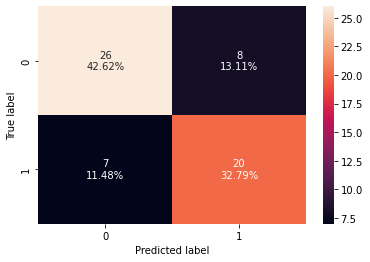

In [50]:
confusion_matrix_statsmodels(lg7, X_test7, y_test, threshold=0.42)

In [51]:
log_reg_model_test_perf_threshold_curve = model_performance_classification_statsmodels(
    lg7, X_test7, y_test, threshold=0.42
)
print("Test performance:")
log_reg_model_test_perf_threshold_curve

Test performance:


,Accuracy,Recall,Precision,F1
0,0.754098,0.740741,0.714286,0.727273


In [52]:
# converting coefficients to odds
odds = np.exp(lg7.params)

# finding the percentage change
perc_change_odds = (np.exp(lg7.params) - 1) * 100

# removing limit from number of columns to display
pd.set_option("display.max_columns", None)

# adding the odds to a dataframe
pd.DataFrame({"Odds": odds, "Change_odd%": perc_change_odds}, index=X_train7.columns).T

,const,Gender,RestECG,MaxHeartRate,ExAngina,PainType_asymptomatic
Odds,7.834495,5.247068,2.044904,0.967786,3.090592,5.824890
Change_odd%,683.449488,424.706822,104.490414,-3.221412,209.059169,482.488987


### Coefficient interpretations

* `Gender`: Holding all other features constant a unit change in Gender will increase the odds of a heart disease happen by 5.24 times or a 424.706% increase in odds.
* `RestECG`: Holding all other features constant a unit change in RestECG will increase the odds of a heart disease happen by 2.04 times or a 104.5% increase in the odds.
* `MaxHeartRate`: Holding all other features constant a unit change in MaxHeartRate will decrease the odds of a heart disease happen by 0.96 times or a 3.22% decrease in the odds.
* `ExAngina`: Holding all other features constant a unit change in ExAngina will increase the odds a heart disease happen by 3.09 times or a 209% increase in the odds.
* `PainType_asymptomatic`: Holding all other features constant a unit change in PainType_asymptomatic will increase the odds of a heart disease happen by 5.82 times or a 482.488% increase in the odds.

## Summary
* All in all, we can see that the logistic regressions are not overfitting. And the highest recall score is 0.74, even though we tune the model change the threshold, the recall score didn't change.
* After tuned the model, the accuracy score even lower. It's probably due to the small size of this dataset.

**Resource:**

[1].“HOW DO I INTERPRET ODDS RATIOS IN LOGISTIC REGRESSION?
Introduction.” OARC Stats, https://stats.oarc.ucla.edu/other/mult-pkg/faq/general/faq-how-do-i-interpret-odds-ratios-in-logistic-regression/. 

[2].“Machine Learning - Confusion Matrix.” Python Machine Learning - Confusion Matrix, https://www.w3schools.com/python/python_ml_confusion_matrix.asp. 

[3].ProteusWRC. “How to Calculate Odds Ratios from Logistic Regression Coefficients.” YouTube, YouTube, 21 Aug. 2018, https://www.youtube.com/watch?v=RDY5MFVbRQE. 

[4].Zach. “How to Create a Precision-Recall Curve in Python.” Statology, 9 Sept. 2021, https://www.statology.org/precision-recall-curve-python/. 

**Link to the ensemble techniques:**
- Our group want to use ensemble techniques to predict soccer game result in the final project, here we use this method to apply on this small dataset as a practice. 
- The highest recall score is 0.75 in our ensemble techniques model, even though it isn't improve too much, we thought that will be a good opportunity to use ensemble techniques.
- https://github.com/ycwang15/Analytics_Programming/blob/main/Y_Wang_Project4_Ensemble_techniques.ipynb

---